In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# from numba import jit

from utils import *


%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

import scipy.sparse as sp
import warnings


class DisjointSet:
    """
    A disjoint set data structure. 
    
    Adapted fro open-source code:
    https://stackoverflow.com/questions/67805907
    """

    class Element:
        def __init__(self):
            self.parent = self
            self.rank = 0

    def __init__(self):
        self.elements = {}

    def find(self, key):
        el = self.elements.get(key, None)
        if not el:
            el = self.Element()
            self.elements[key] = el
        else:  # Path splitting algorithm
            while el.parent != el:
                el, el.parent = el.parent, el.parent.parent
        return el

    def union(self, key=None, *otherkeys):
        if key is not None:
            root = self.find(key)
            for otherkey in otherkeys:
                el = self.find(otherkey)
                if el != root:
                    # Union by rank
                    if root.rank < el.rank:
                        root, el = el, root
                    el.parent = root
                    if root.rank == el.rank:
                        root.rank += 1

    def groups(self):
        result = {el: [] for el in self.elements.values() if el.parent == el}
        for key in self.elements:
            result[self.find(key)].append(key)
        return result


def solve(lists):
    disjoint = DisjointSet()
    for lst in lists:
        disjoint.union(*lst)

    groups = disjoint.groups()
    return [lst and groups[disjoint.find(lst[0])] for lst in lists]


def sparsity(a):
    """Compute the sparsity of a dense matrix"""
    sparsity = 1.0 - (np.count_nonzero(a) / float(a.size))
    return sparsity


def sparsify(a0, sparsity, weighted=False):
    """
    Binarize a matrix by thresholding its values, resulting in a matrix with a given
    sparsity. 
    
    If the matrix contains duplicate elements, thresholding is performed 
    in such a way as to ensure the sparsity is *at least* the requested value
    
    Args:
        a0 (array-like): an array to binarize
        sparsity (float): the target fraction of zeros in the output array
        weighted (bool): Whether to keep sparse-elements or zet them equal to one
    
    Returns
        a (array-like): A binary matrix
    """
    a = a0.copy()
    denom = np.sum(np.ones_like(a))

    thresh1 = np.percentile(a, 100 * sparsity)

    threshes, count = np.unique(np.ravel(a), return_counts=True)
    count_levels = np.cumsum(count) / denom
    thresh_ind = np.where(count_levels > sparsity)[0][0]
    thresh = threshes[thresh_ind]
    thresh = max(thresh1, thresh)

    a[a <= thresh] = 0  # sparsify

    if weighted:
        pass
    else:
        a[a > thresh] = 1
    return a


from scipy.optimize import minimize_scalar, root_scalar


def distance_to_connectivity(dmat, dscale=None, sparsity=None):
    """
    Convert a distance matrix to a connectivity matrix via an exponential transform
    If no crossover scale is specified, one is automatically computed based on a target
    sparsity in the output matrix
    
    Args:
        dmat (array-like): An distance matrix of shape (N, N), or a stack of distance
            matrices of shape (B, N, N)
        dscale (float): The crossover scale for connectivity. This determines the 
            typical distance to be considered connected or not. This setting cannot
            be used with a target sparsity threshold
        sparsity (float): The target fraction of zero entries in the connectivity 
            matrix. This setting cannot be used with a target distance scale
    """
    if (dscale is None) and (sparsity is None):
        sparsity = 0.99  # default case

    if (dscale is not None) and (sparsity is not None):
        warnings.warn(
            "Both a distance scale and a sparsity have been specified; only the"
            + "distance scale will be used"
        )

    if dscale is not None:
        connectivity = np.exp(-dmat / dscale)
        return connectivity

    if sparsity is not None:
        dscale = -np.median(dmat) / np.log(1 - sparsity)
        denom = np.sum(np.ones_like(dmat))
        optfun = lambda x: np.sum(np.exp(-dmat / x)) / denom - (1 - sparsity)

        scale_factor = root_scalar(optfun, bracket=[1e-16, dscale]).root
        connectivity = np.exp(-dmat / scale_factor)
        return connectivity

    return connectivity


def adjmat_from_associations(mat, weighted=False, use_sparse=False):
    """
    Given an association matrix, create an adjacency matrix 
    representing a graph
    
    All non-zero elements occurring within a row  of the input
    matrix are assumed to be densely connected to eachother, 
    forming a clique in the output matrix
    
    Example:
    [0, 1, 1],
    [1, 1, 0],
    [1, 0, 1]
    --->
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
    
    Starting from the edges
    0 -- 1
    0 -- 2
    2 -- 2
    We add the additional edges
    0 -- 0
    1 -- 2
    """

    if use_sparse:
        row_inds = list()
        col_inds = list()
        vals = list()
        for row in mat:
            inds = np.where(row)[0]
            for ind_pair in itertools.combinations(inds, 2):
                row_inds += [ind_pair[0], ind_pair[1]]
                col_inds += [ind_pair[1], ind_pair[0]]
                vals += [1, 1]
        g_adj = sp.csr_matrix((vals, (row_inds, col_inds)), shape=mat.shape)

    # NOT IMPLEMENTED: Weighted
    #     g_adj = g_adj.todense()
    #     if not weighted:
    #         g_adj[g_adj > 0] = 1
    else:

        g_adj = np.zeros(mat.shape)
        for row in mat:
            inds = np.where(row)[0]
            for ind_pair in itertools.combinations(inds, 2):
                g_adj[ind_pair[0], ind_pair[1]] += 1
                g_adj[ind_pair[1], ind_pair[0]] += 1

        ## Is this step even needed?
        if not weighted:
            g_adj[g_adj > 0] = 1

    return g_adj


def _leiden(g, method="graspologic", objective="modularity", resolution=1.0):
    """
    Compute the Leiden clustering of a graph, represented by a numpy matrix or a sparse
    matrix.
    
    Args:
        g (ndarray or sparse_csr_matrix): a representation of a graph as a matrix or 
            sparse matrix.
        method ("graspologic" | "leidenalg" | "igraph" | "cdlib"): The algorithm to use
            to compute the Leiden clustering
        objective ("modularity" | "cpm") : the Leiden clustering method to use
    
    Returns:
        indices (ndarray): An ordered list of indices of nodes in g
        labels (ndarray): A list of labels for each point in indices
    
    """
    if objective not in ["modularity", "cpm"]:
        warnings.warn("Objective function not recognized; falling back to modularity")
        objective = "modularity"
    ## Convert graph to appropriate format
    if method in ["igraph", "leidenalg"]:
        import igraph as ig

        g_ig = ig.Graph.Adjacency(g).as_undirected()

    if method in ["cdlib"]:
        import networkx as nx

        if sp.issparse(g):
            g_nx = nx.convert_matrix.from_scipy_sparse_matrix(g)
        else:
            g_nx = nx.convert_matrix.from_numpy_matrix(g)

    ## Find communities
    if method == "graspologic":
        import graspologic

        mod_flag = objective == "modularity"
        partition = graspologic.partition.leiden(
            g, use_modularity=mod_flag, resolution=resolution
        )
        indices, labels = np.array([(key, partition[key]) for key in partition]).T

    if method == "igraph":
        cluster_obj = g_ig.community_leiden(
            objective_function=objective, resolution_parameter=1.0
        )
        labels = cluster_obj.membership
        indices = np.arange(len(labels))

    if method == "cdlib":
        import cdlib

        if objective == "modularity":
            coms = cdlib.algorithms.leiden(g_nx)
        elif objective == "cpm":
            coms = cdlib.algorithms.cpm(g_nx)
        else:
            warnings.warn(
                "Objective function not recognized; falling back to modularity"
            )
        indices, labels = np.array(community_list_to_labels(coms.communities)).T

    if method == "leidenalg":
        import leidenalg as la

        if objective == "modularity":
            objective_obj = la.ModularityVertexPartition
        else:
            objective_obj = la.CPMVertexPartition
        cluster_membership = la.find_partition(g_ig, objective_obj)
        labels = cluster_membership._membership
        indices = np.arange(len(labels))

    ## sort output
    sort_inds = np.argsort(indices)
    indices, labels = indices[sort_inds], labels[sort_inds]

    return indices, labels


def _embed(X, m):
    """
    Create a time delay embedding of a time series or a set of time series

    Args:
        X (array-like): A matrix of shape (n_series, n_timepoints) or 
            of shape (n_timepoints)
        m (int): The number of dimensions

    Returns:
        Xp (array-like): A time-delay embedding
    """
    Xp = hankel_matrix(X, m)
    Xp = np.moveaxis(Xp, (0, 1, 2), (1, 2, 0))
    return Xp


class RecurrenceModel(BaseEstimator, ClusterMixin):
    """
    A base class for recurrent time series models. This class includes utilities for
    detecting recurrences, and consolidating distance matrices across an ensemble
    
    Attributes:
        tolerance (float): The expected fraction of recurrence events in the time series
            This defaults to 1% of all timepoints. Increasing this parameter improves 
            noise robustness, at the expense of decreasing the detail with which the
            driver can be resolved
        noise (float): The amplitude of the noise used to blur the input data (for 
            regularization).
        make_embedding (bool): Perform a time delay embedding before computing the 
            distance matrix. If multivariate time series are passed, each channel is 
            treated as an independent time series. Otherwise, the time series are 
            assumed to already have been embedded.
        metric ("euclidean" or "dtw"): Not Implemented. The metric to use to compute the
            distance matrix
        time_exclude (int): The number of neighboring timepoints to exclude from the 
            neighborhood calculation
        merge (str): the method of consolidating distances across different timepoints. 
            Defaults to the minimum distance ("min") observed across any response system. 
            Other options include the mean across systems ("mean") and the fifth 
            percentile ("percentile")
        standardize (bool): Whether to standardize the input time series
        use_sparse (bool): Whether to default to sparse matrices
        store_adjacency_matrix (bool): Whether to store the neighbor matrix

    To do:
        Alternative distance metrics; implicit embedding via DTW calculation
        Matrix profile for acceleration
        Subclass for time series motif detection?

    """

    def __init__(
        self,
        tolerance=0.01,
        d_embed=3,
        noise=0.0,
        eps=0.025,
        random_state=None,
        make_embedding=True,
        time_exclude=0,
        standardize=True,
        weighted_connectivity=False,
        merge="min",
        use_sparse=False,
        store_adjacency_matrix=False,
    ):

        self.tolerance = tolerance
        self.eps = eps
        self.make_embedding = make_embedding
        self.d_embed = d_embed
        self.noise = noise
        self.random_state = random_state
        self.time_exclude = time_exclude
        self.merge = merge
        self.weighted_connectivity = weighted_connectivity
        self.standardize = standardize
        self.use_sparse = use_sparse
        self.store_adjacency_matrix = store_adjacency_matrix

    def _make_embedding(self, X):
        np.random.seed(self.random_state)
        X = np.reshape(X, (X.shape[0], -1))
        X = standardize_ts(X)
        ## Time delay embedding
        X_embed = _embed(X, self.d_embed)

        ## Regularization
        if self.noise > 0.0:
            X_embed += self.noise * np.random.normal(size=X_embed.shape)

        return X_embed

    def _find_distance_matrix(self, X):
        """
        Find a minimum distance matrix across an ensemble
        """
        print("distance shape:", X.shape, flush=True)
        all_dist_mat = np.sqrt(
            np.sum((X[..., None, :] - X[:, None, ...]) ** 2, axis=-1)
        ).T
        all_dist_mat += (np.eye(all_dist_mat.shape[0]) * 1e16)[..., None]
        return all_dist_mat

    def _flatten_distance_matrix(self, all_dist_mat, scaled=True):
        """
        Given a stack of distance matrices, flatten to a single consolidated 
        distance matrix.
        """
        all_dist_mat /= np.mean(all_dist_mat, axis=(0, 1), keepdims=True)
        if self.merge == "min":
            dist_mat_accumulated = np.min(all_dist_mat, axis=-1)
        elif self.merge == "kmin":
            k = max(1, int((1 - self.tolerance) * all_dist_mat.shape[-1]))
            dist_mat_accumulated = np.mean(
                np.sort(all_dist_mat, axis=-1)[..., :k], axis=-1
            )
        elif self.merge == "connectivity":
            conn = distance_to_connectivity(all_dist_mat)
            dist_mat_accumulated = np.mean(conn * all_dist_mat, axis=-1)
        elif self.merge == "mean":
            dist_mat_accumulated = np.mean(all_dist_mat, axis=-1)
        elif self.merge == "hmean":
            dist_mat_accumulated = 1 / np.mean(1 / all_dist_mat, axis=-1)
        elif self.merge == "exp_mean":
            dist_mat_accumulated = -np.log(np.mean(np.exp(-all_dist_mat), axis=-1))
        elif self.merge == "percentile":
            dist_mat_accumulated = np.percentile(
                all_dist_mat, 100 * self.tolerance, axis=-1
            )
        else:
            warnings.warn("Reduction method not recognized, falling back to minimum.")
            dist_mat_accumulated = np.min(all_dist_mat, axis=-1)
        # weight_matrix = 1 / dist_mat_min
        print(
            "asymmetry acc: ",
            np.sum(np.abs(dist_mat_accumulated.T - dist_mat_accumulated)),
        )
        return dist_mat_accumulated

    def _threshold_matrix(self, d):
        """
        Binarize a distance matrix or stack of distance matrices
        """
        # print("asymmetry: ", np.sum(np.abs(d.T -  d)))
        if self.weighted_connectivity:
            d = distance_to_connectivity(d, sparsity=(1 - self.tolerance))

        # eps = self.eps
        #         eps = np.percentile(np.ravel(d), 100 * self.tolerance)
        #         print(f"Selected threshold is {eps}")

        #         dist_mat_bin = np.copy(d < eps).astype(int)
        #         print(f"Distance matrix sparsity is is {sparsity(dist_mat_bin)}")

        if len(d.shape) < 3:
            dist_mat_bin = sparsify(d, sparsity=(1 - self.tolerance)).astype(int)
        # stack sparsity
        else:
            dist_mat_bin = np.dstack(
                [
                    # sparsify(d[..., i], (1 - d.shape[-1] * self.tolerance)).astype(int)
                    sparsify(d[..., i], (1 - self.tolerance)).astype(int)
                    for i in range(d.shape[-1])
                ]
            )
            print(dist_mat_bin.shape, d.shape)

        if self.time_exclude > 0:
            mask_mat = np.ones_like(dist_mat_bin)
            mask_mat = 1 - (
                np.triu(mask_mat, k=-self.time_exclude)
                * np.tril(mask_mat, k=self.time_exclude)
            )
            dist_mat_bin *= mask_mat.astype(int)

        return dist_mat_bin

    def _flatten_binary_matrix(self, bdmat):
        """
        Given a stack of binary matrices, flatten along the last dimension
        """
        n = bdmat.shape[-1]
        cmat = np.sum(bdmat, axis=-1)
        cmat = sparsify(cmat, 1 - self.tolerance)
        return cmat

    def _neighbors_to_cliques(self, bdmat):
        """
        Given a binary neighbor matrix, convert to a clique graph
        """
        print("asymmetry: ", np.sum(np.abs(bdmat.T - bdmat)))
        clique_matrix = adjmat_from_associations(
            hollow_matrix(bdmat),
            weighted=self.weighted_connectivity,
            use_sparse=self.use_sparse,
        )
        return clique_matrix


class RecurrenceClustering(RecurrenceModel):
    """
    Cluster timepoints in a set of time series using recurrence families across multiple 
    time series measurements
    """

    def __init__(self, resolution=1.0, **kwargs):
        super().__init__(**kwargs)
        self.resolution = resolution

    def fit(
        self, X, objective="modularity", method="graspologic", use_sparse=False,
    ):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)        
        """
        if self.standardize:
            X = standardize_ts(X)
        X_embed = self._make_embedding(X)
        distance_matrix_stack = self._find_distance_matrix(X_embed)
        distance_matrix = self._flatten_distance_matrix(distance_matrix_stack)
        dist_mat_bin = self._threshold_matrix(distance_matrix)
        #         dist_mat_bin = self._flatten_binary_matrix(
        #             self._threshold_matrix(distance_matrix_stack)
        #         )
        neighbor_matrix = self._neighbors_to_cliques(dist_mat_bin)
        ndim = X_embed.shape[-1]

        indices, labels = _leiden(
            neighbor_matrix,
            resolution=self.resolution,
            objective=objective,
            method=method,
        )
        sort_inds = np.argsort(indices)
        indices, labels = indices[sort_inds], labels[sort_inds]
        reference_indices = np.arange(neighbor_matrix.shape[0])

        #         missing_vals = np.setxor1d(reference_indices, indices)
        #         unclassified_inds = arg_find(reference_indices, missing_vals)

        self.indices = np.copy(reference_indices)
        self.labels_ = -np.ones_like(self.indices)
        self.labels_[indices] = labels

        #         print(indices.shape, labels.shape)
        #         self.indices = indices
        #         self.labels_ = labels
        self.has_unclassified = np.any(self.labels_ < 0)
        self.n_clusters = len(np.unique(self.labels_)) - self.has_unclassified

    def get_driving(self, X):
        """
        Return the best estimate of the driving signal, using a maximum variance 
        heuristic
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
        
        DEV: switch to a heuristic that maximizes spacing
        """
        vals_recon = self._get_full_driving(X)

        # Select best cycle example using largest variance principle
        max_spread_inds = np.argmax(
            np.sum(np.var(vals_recon, axis=1), axis=-1), axis=-1
        )

        vals_recon = vals_recon[np.arange(len(max_spread_inds)), :, max_spread_inds]
        return vals_recon

    def _get_full_driving(self, X):
        """
        Return all possible estimates of the driving signal across system. Negative 
        indices are ignored
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
        
        Returns:
            class_example (np.ndarray): An array of shape (B, T, Te, D), where B is 
                the index of an input dataset for reconstruction, T is the effective 
                time index of the reconstructed signal. Te indexes particular points on 
                the driver. Each value of Te corresponds to a particular driver 
                representation.
        
        """

        X = np.reshape(X, (X.shape[0], -1))
        X = standardize_ts(X)  ## check this
        X_embed = _embed(X, self.d_embed)
        # (B, T, D)

        class_example = list()
        for label in np.unique(self.labels_):
            if label < 0:
                continue
            # class_example.append(X_embed[:, self.labels_==label, :][:, 0])
            class_example.append(X_embed[:, self.labels_ == label, :])
        time_cap = min([item.shape[1] for item in class_example])
        class_example = [item[:, :time_cap] for item in class_example]
        class_example = np.array(class_example)
        class_example = np.moveaxis(class_example, (0, 1, 2), (1, 0, 2))

        return class_example

    def transform(self, X):
        """
        Creates an embedding of a dataset based on the labels list
        
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
            
        """
        cycle_vals = self.get_driving(X)
        all_cycles = list()
        for i in range(cycle_vals.shape[0]):
            sel_inds = self.labels_[self.labels_ >= 0]
            all_cycles.append(cycle_vals[i][sel_inds])
        return np.array(all_cycles)

    def fit_transform(self, X, y=None):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)
            y (ignored) : Not used, present here for consistency with sklearn API
        """
        return self.fit(X).transform(X)


class ClassicalRecurrenceClustering(RecurrenceModel):
    """
    A classical implementation of recurrence clustering, using the original 
    equivalence class algorithm of Sauer (PRL 2004)
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(
        self, X, weighted=False, use_sparse=False,
    ):
        X_embed = self._make_embedding(X)
        distance_matrix_stack = self._find_distance_matrix(X_embed)
        distance_matrix = self._flatten_distance_matrix(distance_matrix_stack)
        dist_mat_bin = self._threshold_matrix(distance_matrix)

        all_merged_inds = list()
        for row in dist_mat_bin:
            all_merged_inds.append(np.sort(np.where(row)[0]))

        merged_inds = solve([list(item) for item in all_merged_inds])
        merged_inds = [np.sort(np.array(item)) for item in merged_inds]
        indlist_lens = np.array([len(item) for item in merged_inds])

        known_items = list()
        item_labels = list()

        for item in merged_inds:
            i = 0
            add_flag = False
            for j, known_item in enumerate(known_items):
                if allclose_len(item, known_item):
                    item_labels.append(j)
                    add_flag = True
            if not add_flag:
                known_items.append(item)
                item_labels.append(i + 1)
        item_labels = np.array(item_labels)

        reference_indices = np.arange(distance_matrix.shape[0])
        #         missing_vals = np.setxor1d(reference_indices, indices)
        #         unclassified_inds = arg_find(reference_indices, missing_vals)
        self.indices = np.copy(reference_indices)
        self.labels_ = item_labels


import scipy
import scanpy as sc


class RecurrenceManifold(RecurrenceModel):
    """
    Assign continuous time index to a set of time series using recurrence families 
    across multiple time series measurements
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(
        self, X, weighted=False, use_sparse=False, root_index=0
    ):
        """
        Args:
            X (array-like): A matrix of shape (n_timepoints, n_features)        
        """
        if self.standardize:
            X = standardize_ts(X)
        X_embed = self._make_embedding(X)
        
        curr_time()

        # Slowest step: compute the distance matrix for each example
        # distance_matrix_stack = self._find_distance_matrix(X_embed)

        ## simplest approach: binarize the min matrix
#         curr_time()
#         dist_mat_bin = self._threshold_matrix(
#             self._flatten_distance_matrix(
#                 distance_matrix_stack
#             )
#         )
#         curr_time()
        
#         ## an alternative approach that dodges the optimizer
#         curr_time()
#         dist_mat_bin = sparsify(
#             dstack_to_connectivity(distance_matrix_stack),
#             1 - self.tolerance,
#             weighted=self.weighted_connectivity
#         )
#         curr_time()
        
        ## an alternative approach that dodges the optimizer
        curr_time()
        root_index, bd = data_to_connectivity(X_embed, return_extremum=True)
        curr_time()
        dist_mat_bin = sparsify(
            bd,
            1 - self.tolerance,
            weighted=self.weighted_connectivity
        )
        curr_time()
        nt = dist_mat_bin.shape[0]
        
        if self.store_adjacency_matrix:
            self.adjacency_matrix = dist_mat_bin
        
        
        #    curr_time()
#                 dist_mat_bin = self._threshold_matrix(
#                     self._flatten_distance_matrix(
#                         distance_matrix_stack
#                     )
#                 )
#                 curr_time()

        ## same as simplest approach
#         curr_time()
#         dist_mat_bin = sparsify(
#             distance_to_connectivity(
#                 self._flatten_distance_matrix(
#                     distance_matrix_stack
#                 )
#             ),
#             1 - self.tolerance,
#             weighted=self.weighted_connectivity
#         )
#         curr_time()

        ### Same as above
#         curr_time()
#         dist_mat_bin = sparsify(
#             np.exp(-self._flatten_distance_matrix(distance_matrix_stack)),
#             1 - self.tolerance,
#             weighted=self.weighted_connectivity,
#         )
#         curr_time()

        #         curr_time()
        #         dist_mat_bin = self._flatten_binary_matrix(
        #             self._threshold_matrix(
        #                 distance_matrix_stack
        #             )
        #         )
        #         curr_time()



        ## Given a connectivity matrix, compute the neighbor graph and then reduce
        print("Matrix sparsity is: ", sparsity(dist_mat_bin))
        curr_time()
        neighbor_matrix = self._neighbors_to_cliques(dist_mat_bin)
        curr_time()
        ndim = X_embed.shape[-1]

        adata = sc.AnnData(0 * X_embed[0, :-ndim, :])
        curr_time()

        sc.pp.neighbors(adata, n_neighbors=3, n_pcs=3)  ## no effect
        curr_time()
        # this distance matrix is not used
        adata.obsp["distances"] = scipy.sparse.csr_matrix(
            0 * neighbor_matrix[: -self.d_embed, : -self.d_embed]
        )
        adata.obsp["connectivities"] = scipy.sparse.csr_matrix(
            neighbor_matrix[: -self.d_embed, :-self.d_embed]
        )
        #root_index = np.argmax(np.mean(dmat, axis=0)) # the point that is typically the furthest from everyone else
        print(root_index)
        adata.uns["iroot"] = root_index # the index of time 0.0 for the driver

        sc.tl.diffmap(adata) # check that this doesn't do anything
        sc.tl.dpt(adata, n_branchings=0) # find maximum spanning tree
        
        pt_vals = np.array(adata.obs["dpt_pseudotime"])
        pt_vals[np.isinf(pt_vals)] = None

        self.indices = np.arange(len(pt_vals))
        self.labels_ = pt_vals

In [3]:
def data_to_connectivity(X, return_extremum=False, merge="mean"):
    """
    Given a stack of M time series, each of shape N x D, compute a 
    single consolidated N x N connectivity or adjacency matrix
    
    Args:
        X (array-like): A list of coordinates of shape M x N x D, where M is the number 
            of time series, N is the number of time points, and D is their 
            dimensionality
        return_extremum (bool): Return the index of the extremum of the timepoints
    """
    
#     bdstack = distance_to_connectivity(dstack) # connectivity matrix
#     dscale = np.mean(dstack, axis=(0, 1), keepdims=True)
#     weights = np.exp(-dstack / dscale) # weights scale each connection by batch scale
#     return np.sum(weights * bdstack, axis=-1)

    nb = X.shape[0]
    
    extrema_ranks = np.zeros(X.shape[1])
    
    ## Iterate over all examples, compute distance matrix
    all_cmats = list()
    for i in range(nb):

        dmat = np.sqrt(
            np.sum((X[i, :, None] - X[i, None, :]) ** 2, axis=-1)
        ).T
        dmat += (np.eye(dmat.shape[0]) * 1e16)
        
        all_cmats.append(
            distance_to_connectivity(dmat, dscale=np.mean(dmat))
        )
        
        # update average distance list
        ave_dists = np.mean(hollow_matrix(dmat), axis=0) / np.mean(hollow_matrix(dmat))
        extrema_ranks += ave_dists / nb
    bdstack = np.dstack(all_cmats)
    
    ## Consolidate into a single adjacency matrix
    if merge == "mean":
        bd = np.mean(bdstack, axis=-1)
    if merge == "percentile":
        bd = np.percentile(bdstack, 95, axis=-1, method='weibull')
    else:
        bd = np.mean(bdstack, axis=-1)
    
    #bd = np.max(bdstack, axis=-1) ## BIG CHANGE
    
    if return_extremum:
        extremum_index = np.argmin(extrema_ranks)
        #extremum_index = np.percentile(extrema_ranks, 5, interpolation='nearest')
        return extremum_index, bd
    return bd

Text(0.5, 1.0, 'PCA components')

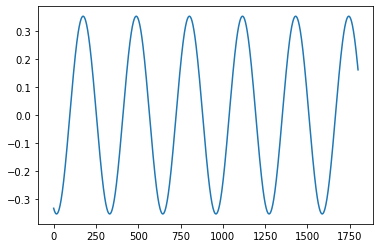

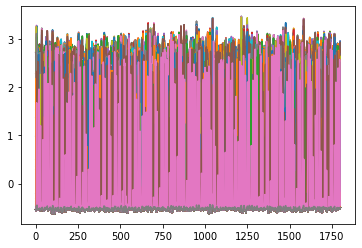

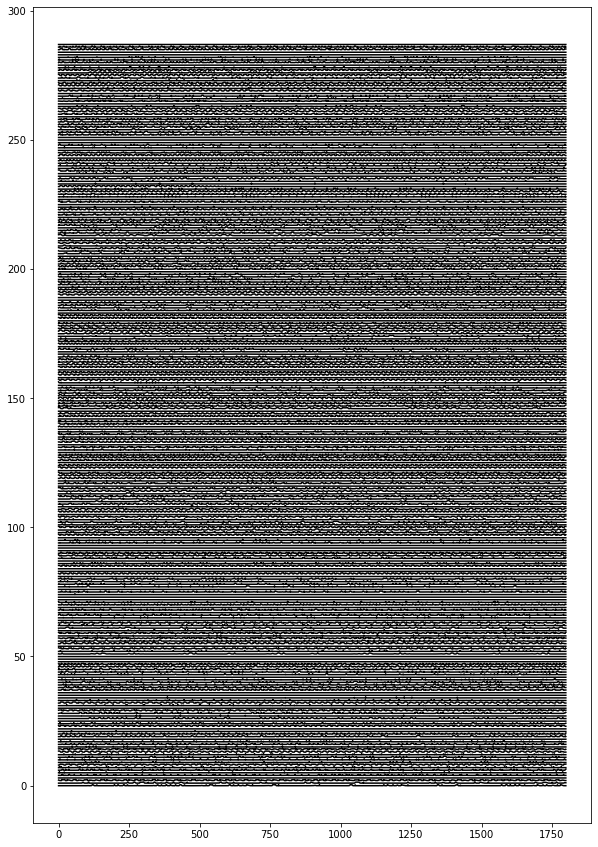

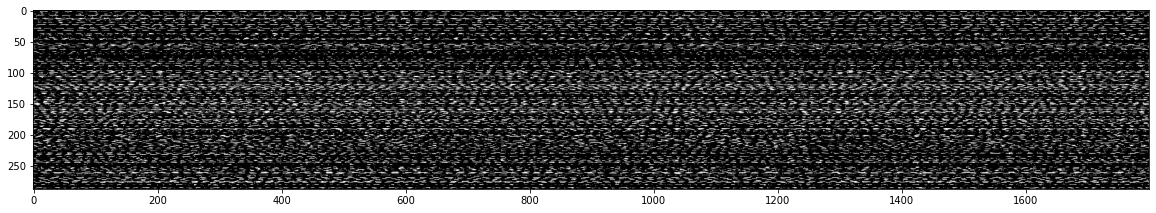

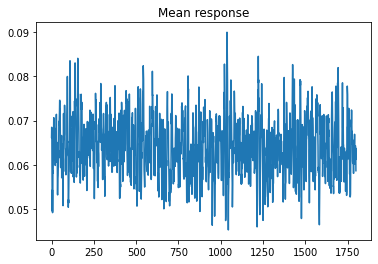

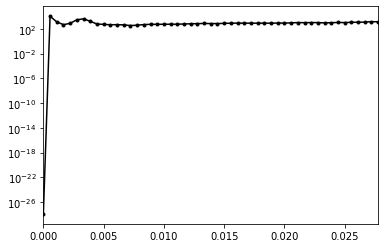

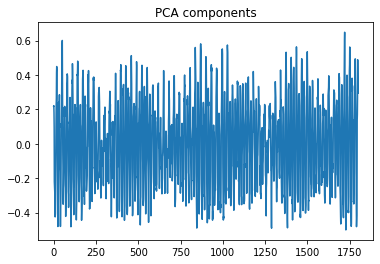

In [4]:
## Continuous-time data
## try FitzHugh-Nagumo as a response system

def rossler(x, y, z, t, a, b, c):
    xdot = -y - z
    ydot = x + a * y
    zdot = b + z * (x - c)
    return xdot, ydot, zdot


def torus(x, y, z, t, a, n, r):
    xdot = (-a * n * np.sin(n * t)) * np.cos(t) - (r + a * np.cos(n * t)) * np.sin(
        t
    )
    ydot = (-a * n * np.sin(n * t)) * np.sin(t) + (r + a * np.cos(n * t)) * np.cos(
        t
    )
    zdot = a * n * np.cos(n * t)
    return xdot, ydot, zdot

def vanderpol(x, y, z, t, a, mu, w):
    ydot = mu * (1 - x ** 2) * y - x + a * np.sin(z)
    xdot = y
    zdot = w
    return xdot, ydot, zdot


class DrivenVanDerPol:
    """
    """

    def __init__(self, random_state=None):
        
        # driver properties
        self.ad = 0.5
        self.n = 5.3
        self.r = 1
        
        # response properties
#         self.ar = 1.2
#         self.mu = 8.53
#         self.w = 0.63
        self.rho = 28
        self.beta = 2.667
        self.sigma = 10
        
        self.n_drive = 3
        self.n_response = 3
        
        ## rossler
        self.a = 0.2
        self.b = 0.2
        self.c = 5.7
        
        np.random.seed(random_state)
        self.n_sys = 24
        self.rho = 28 * (1 + 0.5*(np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        

        self.n_sys = 12 * 3 * 2 * 4
#         self.n_sys = 12 * 3 * 2
#         self.n_sys = 12
        self.rho = 28 * (1 + 1 + 0.5*(np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 0.1*(np.random.random(self.n_sys) - 0.5))
        
        
        
        self.rho = 28 * (1 + 1 + 0.1 * (np.random.random(self.n_sys) - 0.5))
        self.beta = 2.667 * (1 + 0.1 * (np.random.random(self.n_sys) - 0.5))
        self.sigma = 10 * (1 + 2 * (np.random.random(self.n_sys) - 0.5))
        
        
        self.rho = 28 * (1 + 5 * (np.random.random(self.n_sys)))
        self.beta = 2.667 * (1 +  0.1 * (np.random.random(self.n_sys)))
        self.sigma = 10 * (1 + 20 * (np.random.random(self.n_sys) ))
        
        
        
        self.rho = 28 * (1 + 5 * (np.random.random(self.n_sys)))
        self.beta = 2.667 * (1 +  1 * (np.random.random(self.n_sys)))
        self.sigma = 10 * (1 + 10 * (np.random.random(self.n_sys) ))
        

#     def rhs_driver(self, t, X):
#         """
#         Add a quadratic potential in order to attract towards origin
#         """
#         x, y, z = X
#         a, n, r = self.ad, self.n, self.r
#         xdot = (-a * n * np.sin(n * t)) * np.cos(t) - (r + a * np.cos(n * t)) * np.sin(
#             t
#         ) - x
#         ydot = (-a * n * np.sin(n * t)) * np.sin(t) + (r + a * np.cos(n * t)) * np.cos(
#             t
#         ) - y
#         zdot = a * n * np.cos(n * t) - z
#         return xdot, ydot, zdot


    def rhs_driver(self, t, X):
        """Simple periodic driver"""
        x, y, z = X
        a, n, r = self.ad, self.n, self.r
        xdot = a * np.sin(t) - x
        ydot =  a * np.sin(t) - y
        zdot =  a * np.sin(t) - z
        return xdot, ydot, zdot


#     # Rossler driving (aperiodic)
#     def rhs_driver(self, t, X):
#         x, y, z = X
#         a, b, c = self.a, self.b, self.c
#         xdot = -y - z
#         ydot = x + a * y
#         zdot = b + z * (x - c)
#         return xdot * 1.5, ydot * 1.5, zdot* 1.5
    
#     def rhs_response(self, t, X):
#         ar, mu = self.ar, self.mu
#         xd, yd, zd = X[:self.n_drive]
#         x, y, z = X[self.n_drive:]
#         #ydot = mu * (1 - x ** 2) * y - x + ar * np.sin(z)
#         ydot = mu * (1 - x ** 2) * y - x + ar * xd
#         xdot = y
#         zdot = self.w
#         return xdot, ydot, zdot


#     def rhs_response(self, t, X):
#         xd, yd, zd = X[:self.n_drive]
#         x, y, z = X[self.n_drive:]
#         beta, rho, sigma = self.beta, self.rho, self.sigma
#         xdot = sigma * (y - x) + self.ar * xd
#         ydot = x * (rho - z) - y
#         zdot = x * y - beta * z
#         return xdot, ydot, zdot
    
#     def rhs_response_ensemble(self, t, X):
#         Xd = X[0]
#         x, y, z = Xr[::self.n_response], Xr[1::self.n_response], Xr[2::self.n_response]
#         self.rhs_response([Xd, x, y, z])
    
    
    def rhs_response_ensemble(self, t, X):
        
        Xd = X[:self.n_drive]
        Xr = X[self.n_drive:]
        #n_sys = len(np.asarray(sigma))
        
        xd, yd, zd = Xd
        x, y, z = Xr[:self.n_sys], Xr[self.n_sys:2*self.n_sys], Xr[2 * self.n_sys:]

        xdot = self.sigma * (y - x) + self.ar * xd
        ydot = x * (self.rho - z) - y # - self.ar * xd
        zdot = x * y - self.beta * z
        return np.hstack([xdot, ydot, zdot])
    
    def rhs(self, t, X):
        return [*self.rhs_driver(t, X[:self.n_drive]), *self.rhs_response_ensemble(t, X)]
    
eq = DrivenVanDerPol(random_state=0)
eq.ar = 20*4

eq.ar = 20*3


# eq.ar = 20*2 * (np.random.random(eq.n_sys) - 0.5) * 2 # equiv to 20*3
# eq.ar = 20*2 * np.random.choice([-1, 1], eq.n_sys)
eq.ar = 20*4 * np.random.choice([-1, 1], eq.n_sys) 

eq.ar = 20 * np.random.choice([-1, 1], eq.n_sys) 

## periodic
eq.ar = 16 * 20 * np.random.choice([-1, 1], eq.n_sys) # n = 12




# eq.ar = 8 * 20 * np.random.choice([-1, 1], eq.n_sys)



# rossler
# eq.ar =  16 * 20 * 2 * (np.random.random(eq.n_sys)  - 0.5)
# eq.ar = 4 * 20 * np.random.choice([-1, 1], eq.n_sys) # n = 12

from scipy.integrate import solve_ivp
# ic = [-1.4311456845e+00, -2.5294548367e+00,  1.9465770285e-01] + [-1.9778877423e+00,  2.4192328851e-02, 1.2600000000e+02] 
# tpts0 = np.linspace(0, 200, 6000)
# tpts0 = np.linspace(0, 100, 3000)
# sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

ic = np.random.random(3 + 3 * eq.n_sys)
ic[:3] = 0.0
tpts0 = np.linspace(0, 60, 6000)

# tpts0 = np.linspace(0, 2*60, 6000)
# sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

tpts0 = np.linspace(0, 60, 3000)
sol0 = solve_ivp(eq.rhs, [0, np.max(tpts0)], ic, t_eval=tpts0)

sol = sol0.y.T

transient_frac = 0.4
transient_n = int(transient_frac * len(sol))
sol = sol[transient_n:]
tpts = tpts0[:-transient_n]

sol_drive = sol[:, :3]
sol_response = sol[:, 3:]

# for ensemble
sol_response = np.moveaxis(
    np.reshape(
        sol_response,
        (
            sol_response.shape[0], 
            eq.n_sys, 
            -1
        ),
        order="F"
    ),
    (0, 1, 2), 
    (1, 0, 2)
)
X_measure = sol_response[..., 0]

# def tuning(x):
#     n, nt = X_measure.shape
#     shifts = 20 * (np.random.random(n) - 0.5)[:, None]
#     coeffs = 0.05 * np.random.random(n)[:, None]
#     ramp_coeff = 0.001 * np.random.random(n)[:, None]
#     return np.tanh(coeffs * (x- shifts)) + np.arange(nt)[None, :] *  ramp_coeff
# X_measure = tuning(X_measure)

from scipy.stats import norm
def tuning(x):
    """
    Apply random response filters to a measured signal
    """
    n, _ = X_measure.shape
    shifts = 10 * (np.random.random(n) - 0.5)[:, None]
    coeffs = 5 * np.random.random(n)[:, None]
    return norm.pdf((x - shifts) / coeffs)
X_measure = tuning(X_measure)


# def tuning(x):
#     n, nt = X_measure.shape
#     shifts = 20 * (np.random.random(n) - 0.5)[:, None]
#     coeffs = 0.5 * np.random.random(n)[:, None]
#     ramp_coeff = 0.001 * (np.random.random(n)[:, None] - 0.5)
#     return np.cos(coeffs * (x- shifts)) + np.arange(nt)[None, :] *  ramp_coeff
# X_measure = tuning(X_measure)

# jj = 3 * np.random.random(eq.ar.shape)
# X_measure = np.tanh(jj[:, None] * X_measure) * (np.random.random(eq.ar.shape)[:, None] - 0.5)

# X_measure *= 60 * np.sin(
#     ((1/(50 * np.random.random(X_measure.shape[0])))[:, None] * np.arange(X_measure.shape[1])[None, :])
# )

plt.figure()
plt.plot(sol_drive[:, 0].T)


plt.figure()
plt.plot(standardize_ts(X_measure).T);



plt.figure(figsize=(10, 15))
for i in range(X_measure.shape[0]):
    #plt.figure(figsize=(10,1))
    plt.plot(i + (1 / 8) * standardize_ts(X_measure)[i].T, 'k');

# More cycles helps a lot, 
# More systems: non-chaotic systems (pushed out of proper driving) really hurt this
# more diverse subsystems doesn't help

plt.figure(figsize=(20, 15))
plt.imshow(X_measure, cmap="gray")

plt.figure()
plt.plot(np.mean(X_measure, axis=0))
plt.title("Mean response")

plt.figure()
all_psd = list()
for i in range(sol_response.shape[0]):
    freqs, psd = find_psd(sol_response[i, :, 0])
    all_psd.append(psd)
    #plt.semilogy(freqs[:100], psd[:100])
plt.semilogy(freqs, np.mean(np.array(all_psd), axis=0), 'k')
plt.semilogy(freqs, np.mean(np.array(all_psd), axis=0), '.k')
plt.xlim([0, 50/sol_response.shape[1]])



from sklearn.decomposition import PCA
embedding = PCA()
data_transformed = embedding.fit_transform(X_measure.T)
plt.figure()
plt.plot(data_transformed[:, 0]);
# plt.plot(data_transformed[:, 1]);
plt.title("PCA components")

Current Time = 05:09:02
Current Time = 05:09:02


/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/ipykernel_89016/2684347302.py:36: RuntimeWarning: invalid value encountered in true_divide
  ave_dists = np.mean(hollow_matrix(dmat), axis=0) / np.mean(hollow_matrix(dmat))


Current Time = 05:10:06
Current Time = 05:10:06
Matrix sparsity is:  0.9901647740979292
Current Time = 05:10:06
asymmetry:  0.0
Current Time = 05:10:07
Current Time = 05:10:07
Current Time = 05:10:09
0


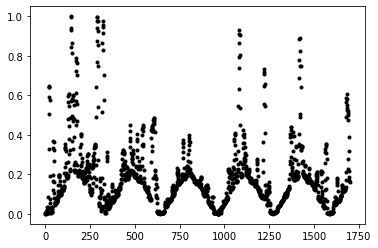

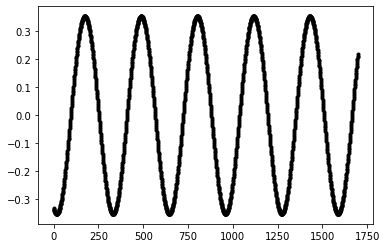

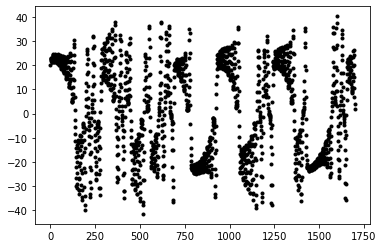

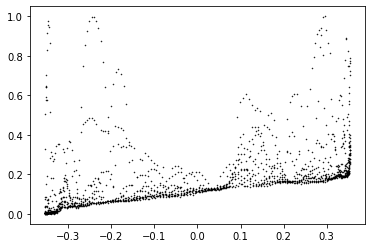

In [5]:
## toggle weighted_connectivity in adjacency matrix factory
vals_response = X_measure.T

# runtime scales with number of ones in distance matrix
# so longer time series can lower tol

# ABLATED WEIGHTING IN ADJMAT CALC -- reduced peak heights, but trend remains
# try ablating connectivity
# try putting mutual condition on before sparsifying: bdmat * bdmat.T / (0.5 * (bdmat + bdmat.T))


# Improve noise smoothing calculation / minima of distance matrices
# Try a non-periodic driver, so we can beat PCA baseline more obviously
# For count data, will have zeros in the distance matrix because there is a finite number
# of elements. Perhaps just add fuzz to the distance matrix?
# Can use ball tree instead of giant distance matrix. Use k nearest neighbors, can add 
# mutual neighbors as an option/flag

model = RecurrenceManifold(weighted_connectivity=True, store_adjacency_matrix=True) 
model = RecurrenceManifold(weighted_connectivity=True, merge="percentile")
# model = RecurrenceManifold(weighted_connectivity=True, merge="kmin")
# model = RecurrenceManifold(weighted_connectivity=True)

# model = RecurrenceClustering(weighted_connectivity=True)
# model = RecurrenceClustering(weighted_connectivity=True, merge="kmin")


label_vals = model.fit_predict(vals_response)





n_plt = 1700

plt.figure()
plt.plot(label_vals[:n_plt], '.k')

plt.figure()
plt.plot(sol_drive[:n_plt, 0], '.k')

plt.figure()
plt.plot(sol_response[0, :n_plt, 0], '.k')

plt.figure()
plt.plot(sol_drive[:n_plt, 0], label_vals[:n_plt], '.k', markersize=1)